In [ ]:
%pip install PyPDF2 nltk pandas
!pip install pdfminer.six
!pip install enchant

In [6]:
import PyPDF2
import nltk
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import enchant
import pdfplumber
from sklearn.model_selection import train_test_split
from joblib import dump
from sklearn.model_selection import GridSearchCV, cross_val_score

#nltk.download('words') -> do that only once
#nltk.download('stopwords') -> do that only once
#nltk.download("punkt") -> do that only once

In [7]:
def find_contents_page(pdf_path):
    with open(pdf_path, "rb") as file:
        pdf_reader = PyPDF2.PdfReader(file)

        start_page = 22
        end_page = 28
        end_page = min(end_page, len(pdf_reader.pages))
        contents_page = ""
        for page_num in range(start_page, end_page):
            page_text = pdf_reader.pages[page_num].extract_text()
            lines = page_text.split('\n')
            page_text = ' '.join(lines)
            contents_page += page_text
        if not contents_page:
            return "Specified pages not found in the PDF"

        return contents_page


In [8]:
def create_csv(sections):
    data = []
    for match in sections:
        chapter = match[0]
        title = match[1]
        page = match[2]

        data.append({"Chapter": chapter, "Title": title, "Page": page})
    df = pd.concat([pd.DataFrame([section]) for section in data], ignore_index=True)

    return df

In [9]:
def extract_sections(contents_text):
    tokens = nltk.word_tokenize(contents_text)
    matches = re.findall(r"(\d+\.\d+)\s+(.*?)\s+(\d+)", contents_text)

    return matches

In [71]:
# Replace 'OS_Main book.pdf' with the path to your PDF file
pdf_path = "Books/os.pdf"
contents_page_text = find_contents_page(pdf_path)

In [87]:
pdf_reader = PyPDF2.PdfReader(pdf_path)
sections = extract_sections(contents_page_text)

In [88]:
sections

[('1.1', 'WhatOperating SystemsDo', '4'),
 ('1.2', 'Computer-SystemOrganization', '7'),
 ('1.3', 'Computer-SystemArchitecture', '15'),
 ('1.4', 'Operating-SystemOperations', '21'),
 ('1.5', 'Resource Management', '27'),
 ('1.6', 'Security and Protection', '33'),
 ('1.7', 'Virtualization', '341'),
 ('1.9', 'KernelDataStructures', '36'),
 ('1.10', 'ComputingEnvironments', '40'),
 ('1.11', 'Free andOpen-Source Operating Systems', '46'),
 ('2.1', 'Operating-SystemServices', '55'),
 ('2.2', 'User andOperating-System Interface', '58'),
 ('2.3', 'System Calls', '62'),
 ('2.4', 'System Services', '74'),
 ('2.5', 'Linkers and Loaders', '75'),
 ('2.6', 'Why Applications Are Operating-SystemSpecific', '772'),
 ('2.8', 'Operating-SystemStructure', '81'),
 ('2.9', 'Building andBootinganOperating System', '92'),
 ('2.10', 'Operating-SystemDebugging', '95'),
 ('2.11', 'Summary', '100'),
 ('3.1', 'Process Concept', '106'),
 ('3.2', 'Process Scheduling', '110'),
 ('3.3', 'OperationsonProcesses', '116')

In [89]:
def add_text_to_content(content_list, pdf_reader): 
    new_content_list = {}
    buffer = ""
    is_initialized = False
    chapter = None
    
    for page_number in range(29, len(pdf_reader.pages)):
        page_content = pdf_reader.pages[page_number].extract_text()
        significant_part = page_content[:11]
        match = re.findall(r"(\d+)CHAPTER", significant_part)
        match_final = re.findall(r"Part Ten\nAppendices\n", page_content[:24])
        if len(match) != 0:
            if int(match[0]) == 1:
                is_initialized = True
                chapter = 1
            else:
                content_list[str(int(match[0]) - 1)] = buffer
                chapter = int(match[0])
                buffer = ""
                
        elif chapter == 21 and len(match_final) != 0:
            content_list["21"] = buffer
            break
            
        if is_initialized:
            buffer += " " + page_content
            

In [90]:
def pre_process_string(string_X):
    processed_string = re.sub(r'\W', ' ', str(string_X))
    processed_string = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_string)
    processed_string = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_string)
    processed_string = re.sub(r'\s+', ' ', processed_string, flags=re.I)
    processed_string = re.sub(r'^b\s+', ' ', processed_string)
    processed_string = re.sub(r'[A-Z]+[a-z]+\d+(\.\d+)?', "", processed_string)
    processed_string = re.sub(r'\d+(\.\d+)?', "", processed_string)
    processed_string = re.sub(r'\s+', ' ', processed_string, flags=re.I)
    processed_string = re.findall(r'[A-Z]+[a-z]*|[a-z]+', processed_string)
    processed_string = ' '.join(processed_string)
    return processed_string.strip()

In [91]:
def predict_label(input_string, model):
    segment_size = 300
    input_segments = split_text(input_string, segment_size)
    input_features = vectorizer.transform(input_segments).toarray()
    predicted_labels = model.predict(input_features)
    return predicted_labels

In [92]:
def get_flattened_content(normal_contents):
    result = {}
    for chapter in normal_contents:
        main = chapter[0].split(".")[0]
        if main not in result.keys():
            result[main] = chapter[1]
        else:
            result[main] += " " + chapter[1]
    return result

In [93]:
flattened_contents = get_flattened_content(sections)

In [94]:
flattened_contents

{'1': 'WhatOperating SystemsDo Computer-SystemOrganization Computer-SystemArchitecture Operating-SystemOperations Resource Management Security and Protection Virtualization KernelDataStructures ComputingEnvironments Free andOpen-Source Operating Systems',
 '2': 'Operating-SystemServices User andOperating-System Interface System Calls System Services Linkers and Loaders Why Applications Are Operating-SystemSpecific Operating-SystemStructure Building andBootinganOperating System Operating-SystemDebugging Summary',
 '3': 'Process Concept Process Scheduling OperationsonProcesses Interprocess Communication IPC in Shared-MemorySystems IPC in Message-Passing Systems Communicationin Client– ServerSystems Summary',
 '4': 'Overview Multicore Programming Multithreading Models ThreadLibraries Implicit Threading Operating-System Examples Summary',
 '5': 'Basic Concepts Scheduling Criteria Scheduling Algorithms ThreadScheduling Multi-Processor Scheduling Real-TimeCPU Scheduling Algorithm Evaluation 

In [95]:
add_text_to_content(flattened_contents, pdf_reader)

In [64]:
pdf_reader.pages[1041].extract_text()

'Part Ten\nAppendices\nModern operating systems such as Linux, mac OS, and Windows 10 have\nbeen inﬂuenced by earlier systems, and here we discuss some of the\nolder and highly inﬂuential operating systems.\nSome of these systems (such as the XDS-940 and the THE system)\nwere one-of-a-kind systems; others (such as OS/360 ) are widely used.\nWe brieﬂy cover some of the older systems that are no longer in use.\nWe also provide comprehensive cover age of three additional systems:\nWindows 7, FreeBSD, and Mach. Windows 7 remains a popular operating\nsystem for many users. The FreeBSD system is another UNIX system.\nHowever, whereas Linux combines features from several UNIX systems,\nFreeBSD is based on the BSD model. FreeBSD source code, like Linux\nsource code, is freely available. Mach also provides compatibility with\nBSD UNIX . What is especially interesting about BSD and Mach is that they\nform the architecture of both i OSand mac OS, two very popular modern\noperating systems.'

In [97]:
dictionary = {"chapter":flattened_contents.keys(), "words":[]}

In [98]:
for section in dictionary["chapter"]:
    dictionary["words"].append(re.sub(r'\b\w{20,}\b', '', 
                                      pre_process_string(flattened_contents[section]).replace(" the", " ").lower()))

In [99]:
df = pd.DataFrame(dictionary)

In [100]:
df["words_number"] = df["words"].apply(lambda x: len(x.split()))

In [101]:
df

,chapter,words,words_number
0,1,chapter introduction anoperating system is sof...,14682
1,2,chapter operating system structures an operati...,14287
2,3,chapter processes thispro gram had complete c...,15960
3,4,chapter threads concurrency the process model ...,11279
4,5,chapter cpu scheduling byswitch ing cpuamong...,15139
5,6,chapter synchronization tools acooperating pro...,9261
6,7,chapter synchronization examples in chapter we...,8552
7,8,chapter deadlocks number of resources thread...,8788
8,9,chapter main memory in chapter we showed how ...,10299
9,10,chapter virtual memory in chapter we discussed...,16594


### Data Augmentation

In [102]:
def split_text(text, segment_size):
    words = text.split()
    segments = [words[i:i+segment_size] for i in range(0, len(words), segment_size)]
    return [' '.join(segment) for segment in segments]

In [103]:
def get_augmented_data(df, segment_size):
    augmented_data = {"chapter": [], "words": []}
    for index, row in df.iterrows():
        chapter = row["chapter"]
        words = row["words"]
        text_segments = split_text(words, segment_size)
        for segment in text_segments:
            augmented_data["chapter"].append(chapter)
            augmented_data["words"].append(segment)

    return pd.DataFrame(augmented_data).sample(frac=1)

In [104]:
augmented_df = get_augmented_data(df, 300)

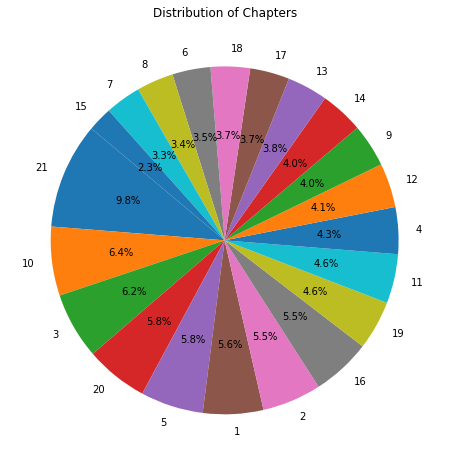

In [105]:
import matplotlib.pyplot as plt
chapter_counts = augmented_df["chapter"].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(chapter_counts, labels=chapter_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Chapters')
plt.show()

In [106]:
vectorizer = TfidfVectorizer(max_features=5000, 
                             min_df=0.01, 
                             max_df=0.85, 
                             stop_words=stopwords.words('english'))
augmented_features = vectorizer.fit_transform(augmented_df["words"]).toarray()

### Machine Learning Algorithms

In [107]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

In [108]:
comparison = {}

In [109]:
def get_statistics(model, X_test, y_test):
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_rep)

    plt.figure(figsize=(10, 6))
    pd.Series(y_pred).value_counts().sort_index().plot(kind='bar', color='darkred')
    plt.xlabel('Chapter')
    plt.ylabel('Count')
    plt.title('Distribution of Predicted Chapters')
    plt.xticks(rotation=45)
    plt.show()

In [110]:
X_train, X_test, y_train, y_test = train_test_split(augmented_features, augmented_df["chapter"], test_size=0.2, 
                                                    random_state=0, stratify=augmented_df["chapter"])

#### Neural Network 

In [111]:
param = {"activation": ["relu", "tanh"],
        "hidden_layer_sizes":[(10), (100), (5, 5), (5, 10), (10, 10), (10, 5), (5, 10, 5)]}
grid = GridSearchCV(MLPClassifier(max_iter=10000), param_grid=param, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,11.861318,0.158881,0.006979,0.000787,relu,10,"{'activation': 'relu', 'hidden_layer_sizes': 10}",0.771429,0.742857,0.785714,0.757143,0.784173,0.768263,0.016351,4
1,28.946343,4.364994,0.012546,0.001006,relu,100,"{'activation': 'relu', 'hidden_layer_sizes': 100}",0.871429,0.792857,0.842857,0.792857,0.870504,0.834101,0.035206,1
2,67.790079,32.109841,0.007199,0.000399,relu,"(5, 5)","{'activation': 'relu', 'hidden_layer_sizes': (...",0.364286,0.114286,0.178571,0.514286,0.553957,0.345077,0.175283,14
3,17.884493,1.495582,0.006652,0.000449,relu,"(5, 10)","{'activation': 'relu', 'hidden_layer_sizes': (...",0.528571,0.571429,0.600000,0.571429,0.625899,0.579466,0.032549,10
4,15.053368,0.657344,0.007407,0.000814,relu,"(10, 10)","{'activation': 'relu', 'hidden_layer_sizes': (...",0.642857,0.664286,0.678571,0.642857,0.683453,0.662405,0.017159,6
5,23.012260,3.237640,0.006505,0.000631,relu,"(10, 5)","{'activation': 'relu', 'hidden_layer_sizes': (...",0.528571,0.378571,0.378571,0.478571,0.575540,0.467965,0.079171,12
6,24.164498,12.398589,0.007001,0.000633,relu,"(5, 10, 5)","{'activation': 'relu', 'hidden_layer_sizes': (...",0.450000,0.457143,0.307143,0.457143,0.374101,0.409106,0.059849,13
7,21.905297,0.557714,0.006910,0.000658,tanh,10,"{'activation': 'tanh', 'hidden_layer_sizes': 10}",0.771429,0.785714,0.750000,0.778571,0.834532,0.784049,0.027928,3
8,34.208300,0.064943,0.012811,0.000408,tanh,100,"{'activation': 'tanh', 'hidden_layer_sizes': 100}",0.850000,0.792857,0.821429,0.792857,0.899281,0.831285,0.040060,2
9,46.962851,3.104960,0.007051,0.000369,tanh,"(5, 5)","{'activation': 'tanh', 'hidden_layer_sizes': (...",0.678571,0.557143,0.564286,0.585714,0.676259,0.612395,0.053920,9


In [115]:
param = [{"activation":["tanh", "relu"],
         "hidden_layer_sizes":[(i) for i in range(40, 65, 2)]}]
grid = GridSearchCV(MLPClassifier(max_iter=10000), param_grid = param, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=10000), n_jobs=-1,
             param_grid=[{'activation': ['tanh', 'relu'],
                          'hidden_layer_sizes': [40, 42, 44, 46, 48, 50, 52, 54,
                                                 56, 58, 60, 62, 64]}])

In [116]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,19.617890,1.089769,0.008860,0.000846,tanh,40,"{'activation': 'tanh', 'hidden_layer_sizes': 40}",0.842857,0.792857,0.828571,0.835714,0.877698,0.835540,0.027208,2
1,19.854725,1.048433,0.010185,0.001180,tanh,42,"{'activation': 'tanh', 'hidden_layer_sizes': 42}",0.835714,0.778571,0.778571,0.792857,0.863309,0.809805,0.033977,26
2,19.941970,0.753905,0.009756,0.000799,tanh,44,"{'activation': 'tanh', 'hidden_layer_sizes': 44}",0.857143,0.778571,0.828571,0.800000,0.884892,0.829836,0.038201,12
3,21.821483,1.706250,0.010365,0.000779,tanh,46,"{'activation': 'tanh', 'hidden_layer_sizes': 46}",0.850000,0.800000,0.828571,0.814286,0.877698,0.834111,0.027348,4
4,19.234234,0.761879,0.010025,0.000600,tanh,48,"{'activation': 'tanh', 'hidden_layer_sizes': 48}",0.871429,0.807143,0.807143,0.800000,0.877698,0.832682,0.034352,5
5,22.773178,1.839249,0.010552,0.001005,tanh,50,"{'activation': 'tanh', 'hidden_layer_sizes': 50}",0.835714,0.778571,0.828571,0.785714,0.877698,0.821254,0.036148,23
6,22.480552,1.565046,0.010599,0.001018,tanh,52,"{'activation': 'tanh', 'hidden_layer_sizes': 52}",0.850000,0.800000,0.828571,0.792857,0.863309,0.826948,0.027366,17
7,22.988431,1.617789,0.011802,0.000400,tanh,54,"{'activation': 'tanh', 'hidden_layer_sizes': 54}",0.864286,0.807143,0.821429,0.800000,0.884892,0.835550,0.033258,1
8,22.786841,1.233770,0.011777,0.000871,tanh,56,"{'activation': 'tanh', 'hidden_layer_sizes': 56}",0.857143,0.807143,0.807143,0.792857,0.863309,0.825519,0.028880,18
9,24.427708,0.896897,0.010545,0.000565,tanh,58,"{'activation': 'tanh', 'hidden_layer_sizes': 58}",0.842857,0.778571,0.835714,0.792857,0.863309,0.822662,0.031821,21


Accuracy: 0.85
Classification Report:
               precision    recall  f1-score   support

           1       0.64      0.70      0.67        10
          10       0.73      0.73      0.73        11
          11       1.00      0.75      0.86         8
          12       1.00      0.71      0.83         7
          13       0.78      1.00      0.88         7
          14       0.71      0.71      0.71         7
          15       0.50      0.25      0.33         4
          16       0.83      1.00      0.91        10
          17       1.00      0.83      0.91         6
          18       1.00      0.83      0.91         6
          19       0.80      1.00      0.89         8
           2       0.90      0.90      0.90        10
          20       0.70      0.70      0.70        10
          21       0.93      0.82      0.87        17
           3       0.85      1.00      0.92        11
           4       0.88      0.88      0.88         8
           5       0.91      1.00      0.9

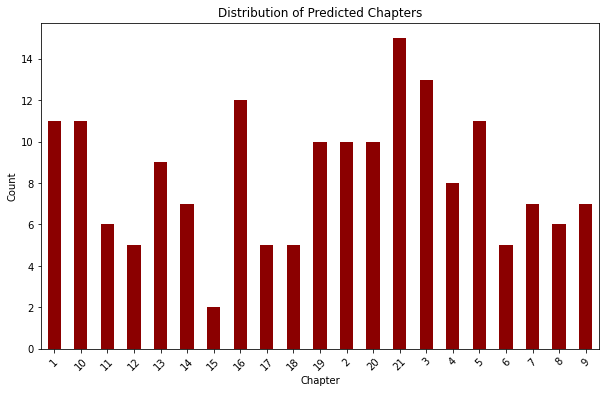

In [117]:
mlp = MLPClassifier(max_iter=10000, activation="tanh", hidden_layer_sizes=(54))
mlp.fit(X_train, y_train)
get_statistics(mlp, X_test, y_test)
comparison["MLP"] = mlp.score(X_test, y_test)

#### SVC

In [118]:
param = {"kernel":["rbf"],
         "C": [1.5, 1.7, 2, 2.2, 2.5, 2.7],
         "gamma": [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2]}
grid = GridSearchCV(SVC(), param_grid=param, cv=4, n_jobs=-1)
grid.fit(X_train, y_train)
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,2.120409,0.051387,0.883483,0.018118,1.5,0.4,rbf,"{'C': 1.5, 'gamma': 0.4, 'kernel': 'rbf'}",0.800000,0.771429,0.754286,0.827586,0.788325,0.027937,18
1,2.083521,0.028242,0.867182,0.021756,1.5,0.5,rbf,"{'C': 1.5, 'gamma': 0.5, 'kernel': 'rbf'}",0.800000,0.777143,0.754286,0.827586,0.789754,0.027172,16
2,2.254995,0.020986,0.863423,0.009653,1.5,0.6,rbf,"{'C': 1.5, 'gamma': 0.6, 'kernel': 'rbf'}",0.788571,0.777143,0.742857,0.827586,0.784039,0.030251,25
3,2.279372,0.025765,0.872110,0.006299,1.5,0.7,rbf,"{'C': 1.5, 'gamma': 0.7, 'kernel': 'rbf'}",0.777143,0.777143,0.754286,0.839080,0.786913,0.031531,20
4,2.237670,0.032830,0.861751,0.010601,1.5,0.8,rbf,"{'C': 1.5, 'gamma': 0.8, 'kernel': 'rbf'}",0.771429,0.771429,0.737143,0.827586,0.776897,0.032441,33
5,2.281048,0.023519,0.862798,0.010876,1.5,0.9,rbf,"{'C': 1.5, 'gamma': 0.9, 'kernel': 'rbf'}",0.760000,0.765714,0.725714,0.833333,0.771190,0.039003,36
6,2.262070,0.026821,0.835243,0.022987,1.5,1,rbf,"{'C': 1.5, 'gamma': 1, 'kernel': 'rbf'}",0.760000,0.748571,0.725714,0.833333,0.766905,0.040290,42
7,2.290671,0.028962,0.874909,0.016507,1.5,1.1,rbf,"{'C': 1.5, 'gamma': 1.1, 'kernel': 'rbf'}",0.760000,0.714286,0.725714,0.816092,0.754023,0.039588,48
8,2.265720,0.015939,0.869095,0.008906,1.5,1.2,rbf,"{'C': 1.5, 'gamma': 1.2, 'kernel': 'rbf'}",0.737143,0.708571,0.708571,0.810345,0.741158,0.041613,54
9,2.244000,0.024963,0.862305,0.020144,1.7,0.4,rbf,"{'C': 1.7, 'gamma': 0.4, 'kernel': 'rbf'}",0.788571,0.777143,0.760000,0.827586,0.788325,0.024844,19


Accuracy: 0.78
Classification Report:
               precision    recall  f1-score   support

           1       0.58      0.70      0.64        10
          10       0.67      0.73      0.70        11
          11       1.00      0.62      0.77         8
          12       1.00      0.71      0.83         7
          13       0.58      1.00      0.74         7
          14       0.71      0.71      0.71         7
          15       0.67      0.50      0.57         4
          16       0.91      1.00      0.95        10
          17       1.00      0.67      0.80         6
          18       1.00      0.67      0.80         6
          19       0.88      0.88      0.88         8
           2       0.67      0.80      0.73        10
          20       0.60      0.60      0.60        10
          21       0.92      0.65      0.76        17
           3       0.85      1.00      0.92        11
           4       0.78      0.88      0.82         8
           5       1.00      1.00      1.0

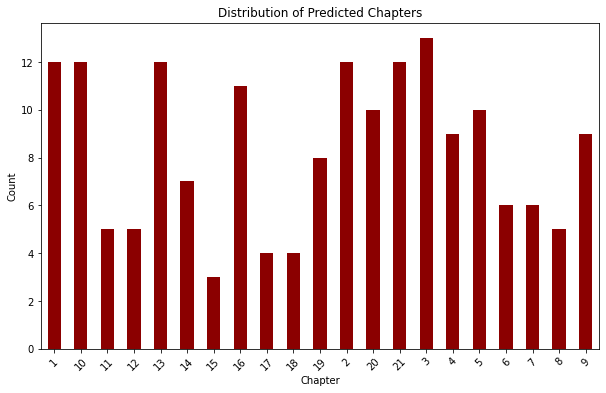

In [119]:
svc_model = SVC(kernel='rbf', C=2.5, gamma=0.4)
svc_model.fit(X_train, y_train)
get_statistics(svc_model, X_test, y_test)
comparison["SVC"] = svc_model.score(X_test, y_test)

#### Random Forest

Accuracy: 0.82
Classification Report:
               precision    recall  f1-score   support

           1       0.82      0.90      0.86        10
          10       0.56      0.82      0.67        11
          11       1.00      1.00      1.00         8
          12       0.83      0.71      0.77         7
          13       0.78      1.00      0.88         7
          14       0.83      0.71      0.77         7
          15       0.50      0.25      0.33         4
          16       0.91      1.00      0.95        10
          17       1.00      0.83      0.91         6
          18       1.00      0.83      0.91         6
          19       0.80      1.00      0.89         8
           2       1.00      0.60      0.75        10
          20       0.67      0.60      0.63        10
          21       0.78      0.82      0.80        17
           3       0.77      0.91      0.83        11
           4       1.00      1.00      1.00         8
           5       1.00      0.90      0.9

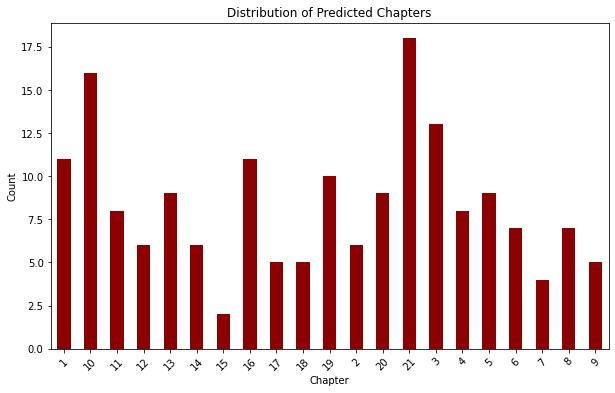

In [120]:
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
rf_classifier.fit(X_train, y_train)
get_statistics(rf_classifier, X_test, y_test)
comparison["Random Forest"] = rf_classifier.score(X_test, y_test)

#### Logistic Regression

In [123]:
param = {"multi_class":["multinomial"],
        "C":range(69, 80)}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid=param, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_multi_class,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.669559,0.162444,0.006175,0.001126,69,multinomial,"{'C': 69, 'multi_class': 'multinomial'}",0.842857,0.785714,0.8,0.8,0.892086,0.824132,0.039010,11
1,3.700001,0.064442,0.007959,0.000848,70,multinomial,"{'C': 70, 'multi_class': 'multinomial'}",0.850000,0.785714,0.8,0.8,0.892086,0.825560,0.039793,1
2,3.754005,0.033143,0.007799,0.000747,71,multinomial,"{'C': 71, 'multi_class': 'multinomial'}",0.850000,0.785714,0.8,0.8,0.892086,0.825560,0.039793,1
3,3.766874,0.138285,0.007542,0.001003,72,multinomial,"{'C': 72, 'multi_class': 'multinomial'}",0.850000,0.785714,0.8,0.8,0.892086,0.825560,0.039793,1
4,3.809429,0.135847,0.007800,0.000398,73,multinomial,"{'C': 73, 'multi_class': 'multinomial'}",0.850000,0.785714,0.8,0.8,0.892086,0.825560,0.039793,1
5,3.885399,0.167715,0.007402,0.000489,74,multinomial,"{'C': 74, 'multi_class': 'multinomial'}",0.850000,0.785714,0.8,0.8,0.892086,0.825560,0.039793,1
6,3.869311,0.055554,0.007692,0.000743,75,multinomial,"{'C': 75, 'multi_class': 'multinomial'}",0.850000,0.785714,0.8,0.8,0.892086,0.825560,0.039793,1
7,3.849277,0.169201,0.008091,0.000785,76,multinomial,"{'C': 76, 'multi_class': 'multinomial'}",0.850000,0.785714,0.8,0.8,0.892086,0.825560,0.039793,1
8,3.716814,0.081337,0.007650,0.001086,77,multinomial,"{'C': 77, 'multi_class': 'multinomial'}",0.850000,0.785714,0.8,0.8,0.892086,0.825560,0.039793,1
9,3.750130,0.231474,0.008319,0.001651,78,multinomial,"{'C': 78, 'multi_class': 'multinomial'}",0.850000,0.785714,0.8,0.8,0.892086,0.825560,0.039793,1


In [124]:
grid.best_params_

{'C': 70, 'multi_class': 'multinomial'}

Accuracy: 0.83
Classification Report:
               precision    recall  f1-score   support

           1       0.67      0.80      0.73        10
          10       0.73      0.73      0.73        11
          11       1.00      0.75      0.86         8
          12       1.00      0.71      0.83         7
          13       0.58      1.00      0.74         7
          14       0.83      0.71      0.77         7
          15       0.50      0.25      0.33         4
          16       0.83      1.00      0.91        10
          17       1.00      0.67      0.80         6
          18       1.00      0.67      0.80         6
          19       0.80      1.00      0.89         8
           2       0.90      0.90      0.90        10
          20       0.78      0.70      0.74        10
          21       0.93      0.82      0.87        17
           3       0.92      1.00      0.96        11
           4       0.78      0.88      0.82         8
           5       0.90      0.90      0.9

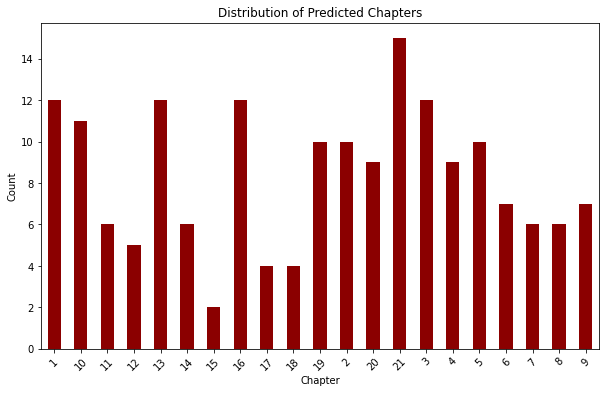

In [125]:
logreg = LogisticRegression(max_iter=1000, multi_class="multinomial", C=70)
logreg.fit(X_train, y_train)
get_statistics(logreg, X_test, y_test)
comparison["Logistic Regression"] = logreg.score(X_test, y_test)

#### Naive Bayes 

In [126]:
param = {"alpha":[i*0.001 for i in range(1, 100)]}
grid = GridSearchCV(MultinomialNB(), param_grid=param, cv=10, n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_params_

{'alpha': 0.007}

Accuracy: 0.81
Classification Report:
               precision    recall  f1-score   support

           1       0.60      0.60      0.60        10
          10       0.75      0.82      0.78        11
          11       1.00      0.62      0.77         8
          12       1.00      0.86      0.92         7
          13       0.83      0.71      0.77         7
          14       0.71      0.71      0.71         7
          15       0.50      0.50      0.50         4
          16       0.83      1.00      0.91        10
          17       1.00      0.83      0.91         6
          18       0.83      0.83      0.83         6
          19       0.80      1.00      0.89         8
           2       0.75      0.90      0.82        10
          20       0.62      0.50      0.56        10
          21       0.93      0.76      0.84        17
           3       0.85      1.00      0.92        11
           4       0.86      0.75      0.80         8
           5       0.90      0.90      0.9

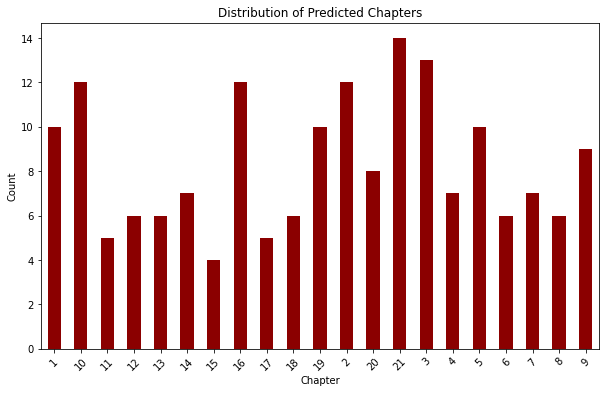

In [127]:
nb = MultinomialNB(alpha=.007)
nb.fit(X_train, y_train)
get_statistics(nb, X_test, y_test)
comparison["Naive Bayes"] = nb.score(X_test, y_test)

#### Comparison

In [128]:
comparison

{'MLP': 0.8457142857142858,
 'SVC': 0.7828571428571428,
 'Random Forest': 0.8171428571428572,
 'Logistic Regression': 0.8342857142857143,
 'Naive Bayes': 0.8057142857142857}

##### Logistic Regression has the best score

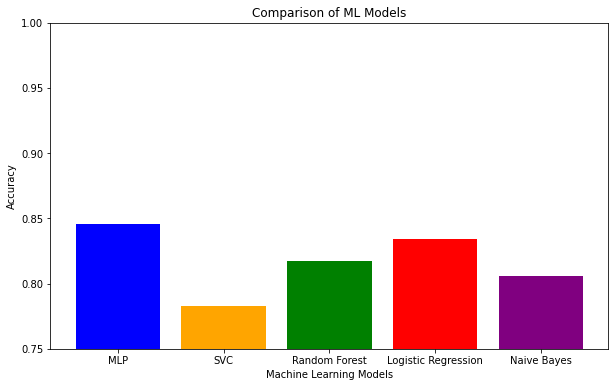

In [130]:
models = list(comparison.keys())
accuracy = list(comparison.values())

plt.figure(figsize=(10, 6))
plt.bar(models, accuracy, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.title('Comparison of ML Models')
plt.xlabel('Machine Learning Models')
plt.ylabel('Accuracy')
plt.ylim(0.75, 1)  
plt.show()

#### Sample prediction 

In [131]:
input_string = """virtual machines and their relationship to contemporary operating
systems. Included is a general description of the hardware and software
techniques that make virtualization possible. This chapter provides an
overview of computer networks and distributed systems, with a focus on
the Internet and TCP/IP."""
predicted_labels = predict_label(input_string, logreg)
print("Predicted Labels:", predicted_labels)

Predicted Labels: ['19']


In [132]:
dump(logreg, 'models/os_book-logistic_regression.joblib')

['models/os_book-logistic_regression.joblib']